In [104]:
import numpy as np
import random
import time
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [105]:
import numba

In [106]:
sns.set(style="whitegrid")
sns.set_palette("tab10")

# Personalización global con matplotlib
plt.rcParams.update({
    'axes.titlesize': 20,        # Tamaño del título
    'axes.titleweight': 'bold',  # Negrita en el título
    'xtick.labelsize': 8,        # Tamaño de los xticks
    'ytick.labelsize': 8,         # Tamaño de los yticks
    'grid.color': 'gray',         # Color de las líneas del grid
    'grid.linestyle': '--',       # Estilo de línea (puede ser '-', '--', '-.', ':')
    'grid.linewidth': 0.5,        # Grosor del grid
    'axes.grid': True,            # Asegura que el grid esté activado
    'axes.grid.axis': 'both',     # Aplica el grid a ambos ejes
    'lines.linewidth': 1.2,       # Grosor de las líneas
    'figure.figsize': (12, 6),   # Tamaño de la figura
})

In [150]:
def cargar_datos(nombre_archivo):
    """
    Loads the Uncapacitated Facility Location Problem instance from a text file.

    Args:
        nombre_archivo (str): The path to the input file.

    Returns:
        tuple: A tuple containing:
            n (int): Number of facilities.
            m (int): Number of clients.
            f_j (list): List of fixed costs for each facility (index 1 to n).
            c_ij (list of lists): 2D list of assignment costs from client i to facility j
                                  (indices 1 to m for clients, 1 to n for facilities).
    """
    with open(nombre_archivo, 'r') as f:
        lineas = f.readlines()

    n, m = map(int, lineas[0].split())

    f_j = [0] * (n + 1)
    c_ij = [[0] * (n + 1) for _ in range(m + 1)]

    for j in range(1, n + 1):
        datos = list(map(int, lineas[j].split()))
        idx = datos[0]
        f_j[idx] = datos[1]
        for i in range(1, m + 1):
            c_ij[i][idx] = datos[i + 1]
    return n, m, f_j, c_ij

In [153]:
import numpy as np
from numba import njit
import random
import time

@njit
def calculate_fitness_numba(open_facility_indices, fixed_costs, transport_costs):
    """
    Calculates the fitness of a solution represented by the indices of open facilities.

    Args:
        open_facility_indices (np.array): 1D array of indices of open facilities.
        fixed_costs (np.array): A 1D array of fixed costs for opening each facility.
        transport_costs (np.array): A 2D array where transport_costs[i][j] is the cost
                                     of transporting goods from facility j to customer i.

    Returns:
        float: The total cost (fitness) of the solution.
    """
    if open_facility_indices.size == 0:
        return 1e10  # High penalty if no facilities are open

    fixed_cost = 0.0
    for index in open_facility_indices:
        fixed_cost += fixed_costs[index]

    transportation_cost = 0.0
    for customer in range(transport_costs.shape[0]):
        min_cost = 1e10
        for facility_index in open_facility_indices:
            cost = transport_costs[customer, facility_index]
            if cost < min_cost:
                min_cost = cost
        transportation_cost += min_cost

    return fixed_cost + transportation_cost

class UFLP_GA:
    """
    A Genetic Algorithm implementation for the Uncapacitated Facility Location Problem (UFLP),
    optimized to represent solutions as lists of open facility indices.
    """

    def __init__(self, n_facilities, n_customers, fixed_costs, transport_costs,
                 population_size=50, mutation_rate=0.1, crossover_rate=0.8,
                 tournament_size=3, max_generations=100, crossover_type='uniform'):
        """
        Initializes the UFLP_GA.

        Args:
            n_facilities (int): The number of potential facility locations.
            n_customers (int): The number of customers to serve.
            fixed_costs (np.array): A 1D array of fixed costs for opening each facility.
            transport_costs (np.array): A 2D array where transport_costs[i][j] is the cost
                                         of transporting goods from facility j to customer i.
            population_size (int): The number of individuals in the population.
            mutation_rate (float): The probability of a gene (facility index) being mutated.
            crossover_rate (float): The probability of two parents undergoing crossover.
            tournament_size (int): The number of individuals participating in tournament selection.
            max_generations (int): The maximum number of generations to run the algorithm.
            crossover_type (str): The type of crossover to use ('uniform' or 'one_point').
        """
        self.n_facilities = n_facilities
        self.n_customers = n_customers
        self.fixed_costs = np.array(fixed_costs[1:])  # Ignore index 0
        self.transport_costs = np.array(transport_costs[1:])[:, 1:]  # Ignore index 0
        self.population_size = population_size
        self.mutation_rate = mutation_rate
        self.crossover_rate = crossover_rate
        self.tournament_size = tournament_size
        self.max_generations = max_generations
        self.crossover_type = crossover_type
        self.population = []
        self.generation = 0
        self.best_solution = None  # Will store indices of open facilities
        self.best_fitness = float('inf')
        self.fitness_history = []

    def _generate_individual(self):
        """
        Generates a random individual represented by a sorted array of open facility indices.
        The number of open facilities is also random (between 1 and n_facilities).
        """
        num_open = random.randint(1, self.n_facilities)
        open_indices = np.sort(np.random.choice(self.n_facilities, size=num_open, replace=False))
        return {'solution': open_indices, 'fitness': None}

    def _initialize_population(self):
        """
        Initializes the population with random sets of open facility indices.
        """
        self.population = [self._generate_individual() for _ in range(self.population_size)]
        self._evaluate_population()
        self.population.sort(key=lambda ind: ind['fitness'])
        self.best_solution = self.population[0]['solution'].copy()
        self.best_fitness = self.population[0]['fitness']
        self.fitness_history.append(self.best_fitness)

    def _calculate_fitness(self, individual):
        """
        Calculates the fitness of an individual (list of open facility indices).
        """
        return calculate_fitness_numba(
            individual['solution'],
            self.fixed_costs,
            self.transport_costs
        )

    def _evaluate_population(self):
        """
        Evaluates the fitness of each individual in the population.
        """
        for individual in self.population:
            individual['fitness'] = self._calculate_fitness(individual)
            if individual['fitness'] < self.best_fitness:
                self.best_fitness = individual['fitness']
                self.best_solution = individual['solution'].copy()

    def _tournament_selection(self):
        """
        Selects a parent using tournament selection.
        """
        tournament = random.sample(self.population, self.tournament_size)
        winner = min(tournament, key=lambda ind: ind['fitness'])
        return winner

    def _uniform_crossover(self, parent1, parent2):
        """
        Performs uniform crossover between two parents (lists of open facility indices).
        The offspring will have a combination of the open facilities from both parents.
        """
        set1 = set(parent1['solution'])
        set2 = set(parent2['solution'])
        union_set = set1.union(set2)
        intersection_set = set1.intersection(set2)

        offspring1_indices = []
        offspring2_indices = []

        for facility_index in union_set:
            if random.random() < 0.5:
                offspring1_indices.append(facility_index)
            else:
                offspring2_indices.append(facility_index)

        # Ensure at least one facility is open
        if not offspring1_indices:
            offspring1_indices.append(random.choice(list(union_set)))
        if not offspring2_indices:
            offspring2_indices.append(random.choice(list(union_set)))

        return {'solution': np.sort(np.array(list(offspring1_indices))), 'fitness': None}, \
               {'solution': np.sort(np.array(list(offspring2_indices))), 'fitness': None}

    def _one_point_crossover(self, parent1, parent2):
        """
        Performs one-point crossover on the sorted lists of open facility indices.
        """
        solution1 = parent1['solution']
        solution2 = parent2['solution']
        len1 = len(solution1)
        len2 = len(solution2)

        if len1 < 2 or len2 < 2:
            return self._uniform_crossover(parent1, parent2) # Fallback to uniform if too short

        crossover_point1 = random.randint(1, len1 - 1)
        crossover_point2 = random.randint(1, len2 - 1)

        offspring1_indices = np.sort(np.concatenate((solution1[:crossover_point1], solution2[crossover_point2:])))
        offspring2_indices = np.sort(np.concatenate((solution2[:crossover_point2], solution1[crossover_point1:])))

        # Ensure at least one facility is open
        if not offspring1_indices.size:
            offspring1_indices = np.array([random.choice(np.concatenate((solution1, solution2)))])
        if not offspring2_indices.size:
            offspring2_indices = np.array([random.choice(np.concatenate((solution1, solution2)))])

        return {'solution': offspring1_indices, 'fitness': None}, {'solution': offspring2_indices, 'fitness': None}

    def _crossover_operator(self, parent1, parent2):
        """
        Selects and performs the specified crossover operation.
        """
        if self.crossover_type == 'uniform':
            return self._uniform_crossover(parent1, parent2)
        elif self.crossover_type == 'one_point':
            return self._one_point_crossover(parent1, parent2)
        else:
            raise ValueError("Unknown crossover type")

    def _mutate(self, individual):
        """
        Performs mutation on an individual (list of open facility indices).
        Mutation can either add a new facility, remove an existing one, or swap one with a closed one.
        """
        mutated_indices = list(individual['solution'])
        num_open = len(mutated_indices)

        if random.random() < self.mutation_rate:
            if num_open > 1 and random.random() < 0.33:  # Remove a facility
                remove_index = random.randint(0, num_open - 1)
                mutated_indices.pop(remove_index)
            elif num_open < self.n_facilities and random.random() < 0.66:  # Add a facility
                closed_indices = np.array([i for i in range(self.n_facilities) if i not in mutated_indices])
                if closed_indices.size > 0:
                    add_index = random.choice(closed_indices)
                    mutated_indices.append(add_index)
            elif num_open > 0 and self.n_facilities > num_open: # Swap a facility
                remove_index = random.randint(0, num_open - 1)
                closed_indices = np.array([i for i in range(self.n_facilities) if i not in mutated_indices])
                if closed_indices.size > 0:
                    add_index = random.choice(closed_indices)
                    mutated_indices[remove_index] = add_index

        return {'solution': np.sort(np.array(mutated_indices)), 'fitness': None}

    def _replacement(self, new_population):
        """
        Replaces the old population with a new population using elitism.
        """
        for individual in new_population:
            if individual['fitness'] is None:
                individual['fitness'] = self._calculate_fitness(individual)
        new_population.append({'solution': self.best_solution.copy(), 'fitness': self.best_fitness})
        new_population.sort(key=lambda ind: ind['fitness'])
        self.population = new_population[:self.population_size]

    def run(self):
        """
        Runs the genetic algorithm.

        Returns:
            tuple: Best solution (indices of open facilities), best fitness, fitness history, execution time, number of generations.
        """
        start_time = time.time()
        self._initialize_population()

        for generation in range(self.max_generations):
            self.generation = generation
            new_population = []
            while len(new_population) < self.population_size - 1:
                parent1 = self._tournament_selection()
                parent2 = self._tournament_selection()
                if random.random() < self.crossover_rate:
                    offspring1, offspring2 = self._crossover_operator(parent1, parent2)
                    new_population.append(self._mutate(offspring1))
                    new_population.append(self._mutate(offspring2))
                else:
                    new_population.append(self._mutate({'solution': parent1['solution'].copy(), 'fitness': None}))
                    new_population.append(self._mutate({'solution': parent2['solution'].copy(), 'fitness': None}))

            self._replacement(new_population)
            self._evaluate_population()
            self.fitness_history.append(self.best_fitness)

            # Optional convergence check
            # if len(self.fitness_history) > 50 and np.std(self.fitness_history[-50:]) < 1e-6:
            #     print(f"Convergence reached at generation {generation + 1}")
            #     break

        end_time = time.time()
        return self.best_solution, self.best_fitness, self.fitness_history, end_time - start_time, self.generation + 1




In [163]:
file_name = 'UFLP-10'

In [164]:
configurations = [
    {"population_size": 50, "mutation_rate": 0.1, "crossover_rate": 0.8, "tournament_size": 3, "max_generations": 300, "crossover_type": "uniform"},
    {"population_size": 100, "mutation_rate": 0.2, "crossover_rate": 0.7, "tournament_size": 5, "max_generations": 300, "crossover_type": "one_point"}
]

In [165]:
num_runs = 10
results = {}
output_dir = "uflp_ga_results"
os.makedirs(os.path.join(output_dir, file_name), exist_ok=True)
RANDOM_SEED = 8

In [166]:
n_facilities, n_customers, fixed_costs, transport_costs = cargar_datos(file_name+'.txt')

In [168]:
print(f"Running GA for {file_name} with random seed: {RANDOM_SEED}\n")

for config in configurations:
    config_name = f"PopSize_{config['population_size']}_MutRate_{config['mutation_rate']}_CrossRate_{config['crossover_rate']}_TournSize_{config['tournament_size']}_MaxGen_{config['max_generations']}_{config['crossover_type']}"
    print(f"--- Running configuration: {config_name} ---")
    results[config_name] = []

    for run in range(num_runs):
        ga = UFLP_GA(n_facilities, n_customers, fixed_costs, transport_costs,
                     config["population_size"], config["mutation_rate"], config["crossover_rate"],
                     config["tournament_size"], config["max_generations"])
        if config["crossover_type"] == "uniform":
            ga._crossover_operator = ga._uniform_crossover
        elif config["crossover_type"] == "one_point":
            ga._crossover_operator = ga._one_point_crossover
        else:
            raise ValueError(f"Unknown crossover type: {config['crossover_type']}")

        best_solution, best_fitness, fitness_history, execution_time, num_generations = ga.run()
        results[config_name].append({
            "best_solution": best_solution,
            "best_cost": best_fitness,
            "execution_time": execution_time,
            "num_generations": num_generations,
            "fitness_history": fitness_history
        })
        print(f"Run {run + 1}/{num_runs}: Best Cost = {best_fitness:.2f}, Time = {execution_time:.2f}s, Generations = {num_generations}")
    print("\n")

Running GA for UFLP-10 with random seed: 8

--- Running configuration: PopSize_50_MutRate_0.1_CrossRate_0.8_TournSize_3_MaxGen_300_uniform ---
Run 1/10: Best Cost = 260180.00, Time = 0.53s, Generations = 300
Run 2/10: Best Cost = 261034.00, Time = 0.55s, Generations = 300
Run 3/10: Best Cost = 259783.00, Time = 0.69s, Generations = 300
Run 4/10: Best Cost = 260248.00, Time = 0.56s, Generations = 300
Run 5/10: Best Cost = 259672.00, Time = 0.53s, Generations = 300
Run 6/10: Best Cost = 260012.00, Time = 0.52s, Generations = 300
Run 7/10: Best Cost = 260300.00, Time = 0.54s, Generations = 300
Run 8/10: Best Cost = 260023.00, Time = 0.55s, Generations = 300
Run 9/10: Best Cost = 260074.00, Time = 0.59s, Generations = 300
Run 10/10: Best Cost = 260172.00, Time = 0.50s, Generations = 300


--- Running configuration: PopSize_100_MutRate_0.2_CrossRate_0.7_TournSize_5_MaxGen_300_one_point ---
Run 1/10: Best Cost = 258712.00, Time = 1.96s, Generations = 300
Run 2/10: Best Cost = 258361.00, Time

In [183]:
# Assuming you have already created an instance of UFLP_GA called 'ga'
transport_matrix = ga.transport_costs
print("Transport Matrix:")
print(transport_matrix)

Transport Matrix:
[[1685 1219 1072 ... 1873 1015 1727]
 [1219 1143 1580 ... 1360 1435 1304]
 [1072 1580 1180 ... 1275 1484 1833]
 ...
 [1873 1360 1275 ... 1271 1446 1873]
 [1015 1435 1484 ... 1446 1563 1846]
 [1727 1304 1833 ... 1873 1846 1193]]


In [169]:
summary_tables = {}
for config_name, run_results in results.items():
    costs = [res["best_cost"] for res in run_results]
    times = [res["execution_time"] for res in run_results]
    best_cost = min(costs)
    worst_cost = max(costs)
    mean_cost = np.mean(costs)
    std_dev_cost = np.std(costs)
    mean_time = np.mean(times)
    percent_deviation = (worst_cost - best_cost) / best_cost * 100 if best_cost != 0 else np.inf

    summary_tables[config_name] = pd.DataFrame({
        "Metric": ["Best Cost", "Worst Cost", "Mean Cost", "Std Dev Cost", "Mean Execution Time (s)", "Percent Deviation (%)"],
        "Value": [f"{best_cost:.2f}", f"{worst_cost:.2f}", f"{mean_cost:.2f}", f"{std_dev_cost:.2f}", f"{mean_time:.2f}", f"{percent_deviation:.2f}"]
    })
    
    os.makedirs(os.path.join(output_dir, file_name, config_name), exist_ok=True)

print("\n--- Summary Statistics per Configuration ---")
for config_name, summary_df in summary_tables.items():
    print(f"\nConfiguration: {config_name}")
    print(summary_df.to_string(index=False))
    summary_df.to_csv(os.path.join(output_dir, file_name, config_name, f"summary.csv"), index=False)


--- Summary Statistics per Configuration ---

Configuration: PopSize_50_MutRate_0.1_CrossRate_0.8_TournSize_3_MaxGen_300_uniform
                 Metric     Value
              Best Cost 259672.00
             Worst Cost 261034.00
              Mean Cost 260149.80
           Std Dev Cost    349.15
Mean Execution Time (s)      0.56
  Percent Deviation (%)      0.52

Configuration: PopSize_100_MutRate_0.2_CrossRate_0.7_TournSize_5_MaxGen_300_one_point
                 Metric     Value
              Best Cost 258345.00
             Worst Cost 258809.00
              Mean Cost 258483.60
           Std Dev Cost    152.84
Mean Execution Time (s)      2.02
  Percent Deviation (%)      0.18


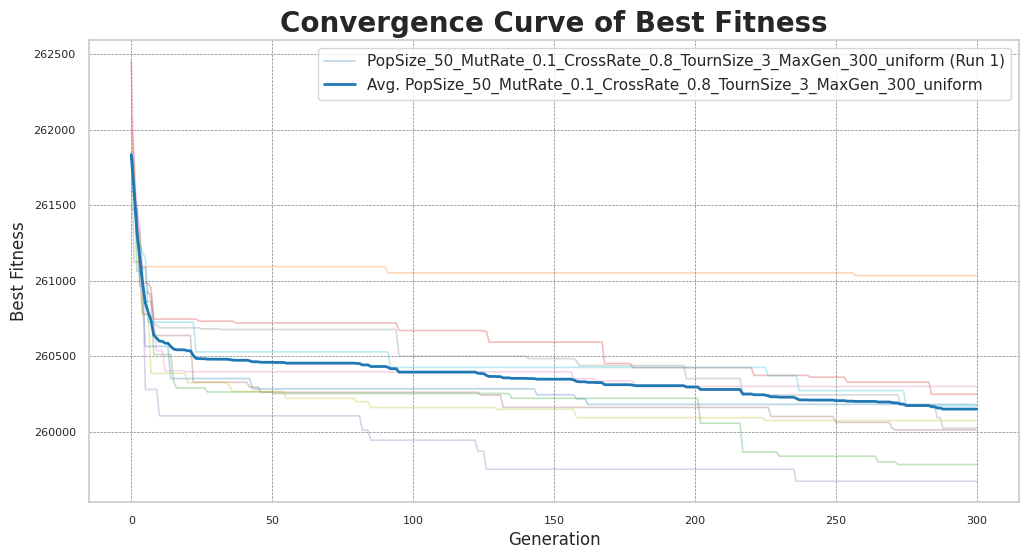

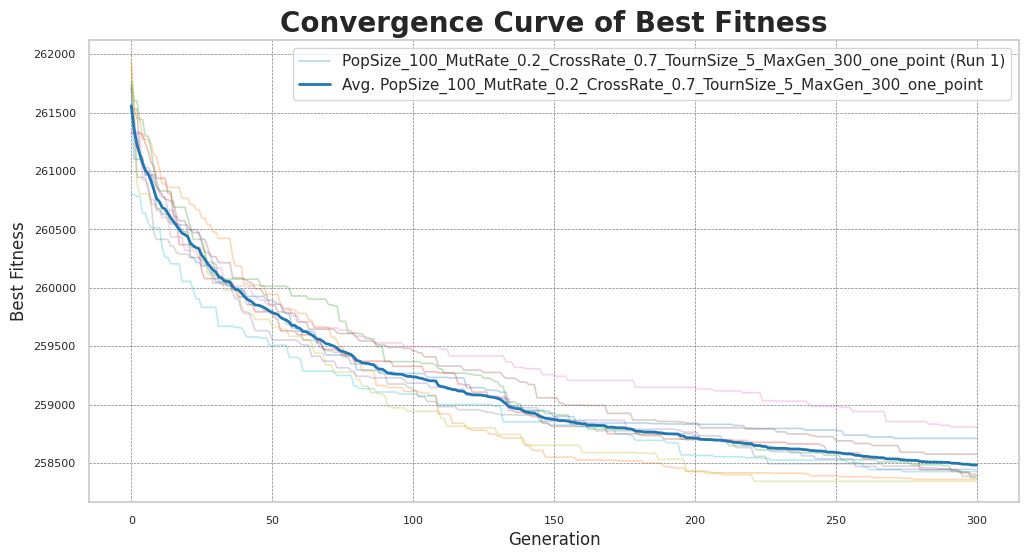

In [170]:
plt.figure(figsize=(12, 6))
for config_name, run_results in results.items():
    for i, res in enumerate(run_results):
        plt.plot(res["fitness_history"], label=f"{config_name} (Run {i+1})" if i == 0 else "", alpha=0.3)
    min_length = min(len(res["fitness_history"]) for res in run_results)
    truncated_histories = [res["fitness_history"][:min_length] for res in run_results]
    avg_fitness_history = np.mean(truncated_histories, axis=0)
    plt.plot(avg_fitness_history, label=f"Avg. {config_name}", linewidth=2)
    plt.xlabel("Generation")
    plt.ylabel("Best Fitness")
    plt.title("Convergence Curve of Best Fitness")
    plt.legend()
    plt.grid(True)
    plt.show()
    plt.savefig(os.path.join(output_dir, file_name, config_name, f"convergence_curves.svg"), format='svg')
    plt.close()

In [119]:
# get the complete name of the confignames
completename = ""
for config in results.keys():
    completename += config

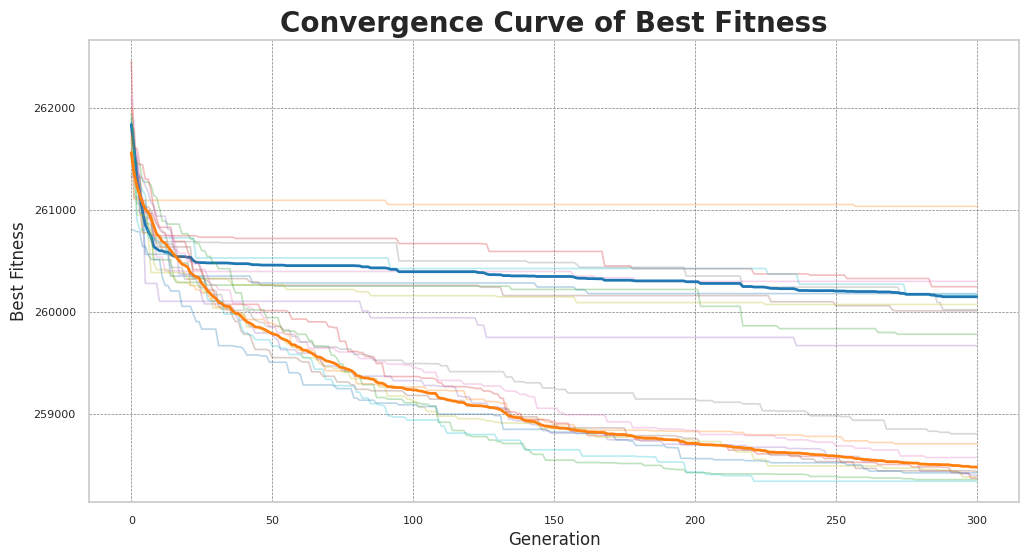

In [171]:
plt.figure(figsize=(12, 6))
for config_name, run_results in results.items():
    for i, res in enumerate(run_results):
        plt.plot(res["fitness_history"], label=f"{config_name} (Run {i+1})" if i == 0 else "", alpha=0.3)
    min_length = min(len(res["fitness_history"]) for res in run_results)
    truncated_histories = [res["fitness_history"][:min_length] for res in run_results]
    avg_fitness_history = np.mean(truncated_histories, axis=0)
    plt.plot(avg_fitness_history, label=f"Avg. {config_name}", linewidth=2)
plt.xlabel("Generation")
plt.ylabel("Best Fitness")
plt.title("Convergence Curve of Best Fitness")


plt.grid(True)
plt.show()
plt.savefig(os.path.join(output_dir, file_name, f"{completename} convergence_curves.svg"), format='svg')
plt.close()

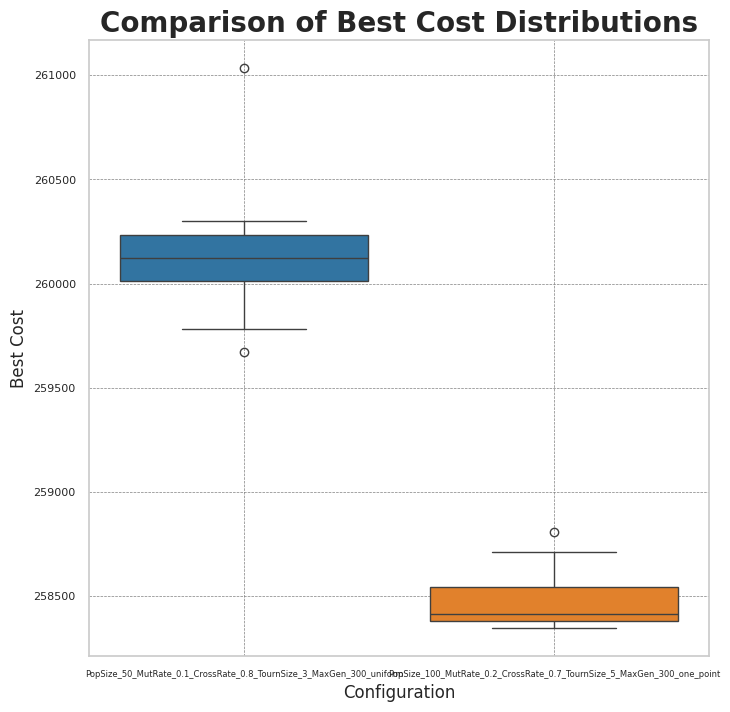

In [172]:
cost_data = {config_name: [res["best_cost"] for res in run_results] for config_name, run_results in results.items()}
plt.figure(figsize=(8, 8))
sns.boxplot(data=pd.DataFrame(cost_data)).set(
    xlabel="Configuration",
    ylabel="Best Cost",
    title="Comparison of Best Cost Distributions"
)
plt.xticks(fontsize=6)
plt.grid(True)
plt.savefig(os.path.join(output_dir, file_name, f"{completename} boxplot.svg"), format='svg')
plt.show()
plt.close()

In [ ]:
print("\n--- Best Solutions Found ---")
for config_name, run_results in results.items():
    best_run = min(run_results, key=lambda x: x["best_cost"])
    print(f"\nConfiguration: {config_name}")
    print(f"  Best Solution (Open Facilities): {best_run['best_solution']}")
    print(f"  Best Cost: {best_run['best_cost']:.2f}")

print(f"\nResults saved to directory: {output_dir}")
print(f"\nRandom seed used for reproducibility: {RANDOM_SEED}")


--- Best Solutions Found ---

Configuration: PopSize_50_MutRate_0.1_CrossRate_0.8_TournSize_3_MaxGen_300_uniform
  Best Solution (Open Facilities): [  9  46  49  50  67  68  69  70  73  77  79  87  89  94 112 122 125 132
 133 134 160 171 172 177 182 192 206 209 212 228 230 238]
  Best Cost: 259672.00

Configuration: PopSize_100_MutRate_0.2_CrossRate_0.7_TournSize_5_MaxGen_300_one_point
  Best Solution (Open Facilities): [  3   4  18  26  33  47  49  60  76  83 104 111 114 116 122 133 156 158
 161 172 194 200 204 206 207 209 213 225 227 230 234 236 240 242 250]
  Best Cost: 258345.00

Results saved to directory: uflp_ga_results

Random seed used for reproducibility: 8


In [175]:
for config_name, run_results in results.items():
    text = ""
    best_run = min(run_results, key=lambda x: x["best_cost"])
    open_facilities_local = np.where(best_run["best_solution"] == 1)[0] + 1  # adjust index
    text += f"\nConfiguration: {config_name}\n"
    text += f"  Best Solution (Open Facilities): {open_facilities_local}\n"
    text += f"  Best Cost: {best_run['best_cost']:.2f}\n"
    text += f"\nResults saved to directory: {output_dir}\n"
    text += f"\nRandom seed used for reproducibility: {RANDOM_SEED}\n"

    file_path = os.path.join(output_dir, file_name, config_name, "best_solutions.txt")
    with open(file_path, "w") as f:
        f.write(text)

    print("Text saved to", file_path)


Text saved to uflp_ga_results/UFLP-10/PopSize_50_MutRate_0.1_CrossRate_0.8_TournSize_3_MaxGen_300_uniform/best_solutions.txt
Text saved to uflp_ga_results/UFLP-10/PopSize_100_MutRate_0.2_CrossRate_0.7_TournSize_5_MaxGen_300_one_point/best_solutions.txt
